# Uncertainty Estimates
We measure uncertainty in many different ways. There can be uncertainty in some parameter estimation (e.g. the mean), and the can be uncertainty in predictions. We use different statistical tools to help us manage and understand this uncertainty. 

### Confidence Intervals

In [11]:
from matplotlib import pyplot
import datetime, matplotlib, numpy, pandas, random, scipy, seaborn
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import scipy as sp
import scipy.stats
import numpy as np
pyplot.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (15, 9)

Say we are trying to figure how likely it is for `Joe Biden` to win the election vs `Donald Trump`. Ideally, we'd like to talk to every potential voter, and ask whether or that they'd vote for `Joe` — this would give us the population proprtion, $p$. Since that's not possible, we can sample the distribution and get the sample proportion, $\hat{p}$, that support `Joe Biden`. 

Confidence intervals help us answer the question, for a given $\hat{p}$ what is the probability that it's within $2\sigma_{\hat{p}}$ of the population proportion $p$. Where $\sigma_{\hat{p}} = \sqrt{\frac{p(1-p)}{n}}$. The `margin of error` is $2\sigma

We know that the mean of the sampling distribution is going to be the population proportion. We also know what the standard deviation will be.

% that fall within the shaded area: 0.95


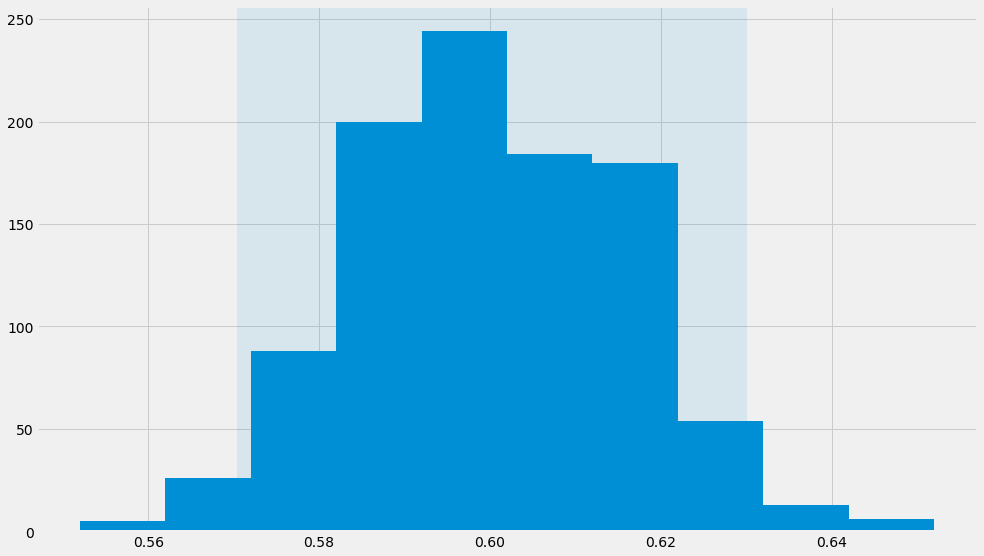

In [40]:
p_biden, n = 0.6, 1000

means, sigmas = [], []
for i in np.arange(1000):
    sample = np.random.binomial(1, p_biden, size=n)
    means.append(sample.mean())
    sigmas.append(sample.std())

sig = np.std(means)
plt.hist(means)
lower, upper = np.mean(means)-sig*1.96, np.mean(means)+sig*1.96
plt.axvspan(lower, upper, alpha=0.1)

ci = np.where((means >= lower) & (means <= upper))[0].shape[0] / len(means)
print(f"% that fall within the shaded area: {ci}")

----

<i>Note: The content of the rest of this notebook comes almost entirely from Eric Bernhardon's blog</i>

Let's generated a driving example

In [12]:
def generate_time_series(k=200, m=1000, sigma=100, n=50, 
                         start_date=datetime.date(2017, 7, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, sigma) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    x_scale = numpy.linspace(-1, 2, 500) # for plotting
    t_scale = [start_date + datetime.timedelta(x)*365 for x in x_scale]
    return xs, ys, ts, x_scale, t_scale

xs, ys, ts, x_scale, t_scale = generate_time_series()

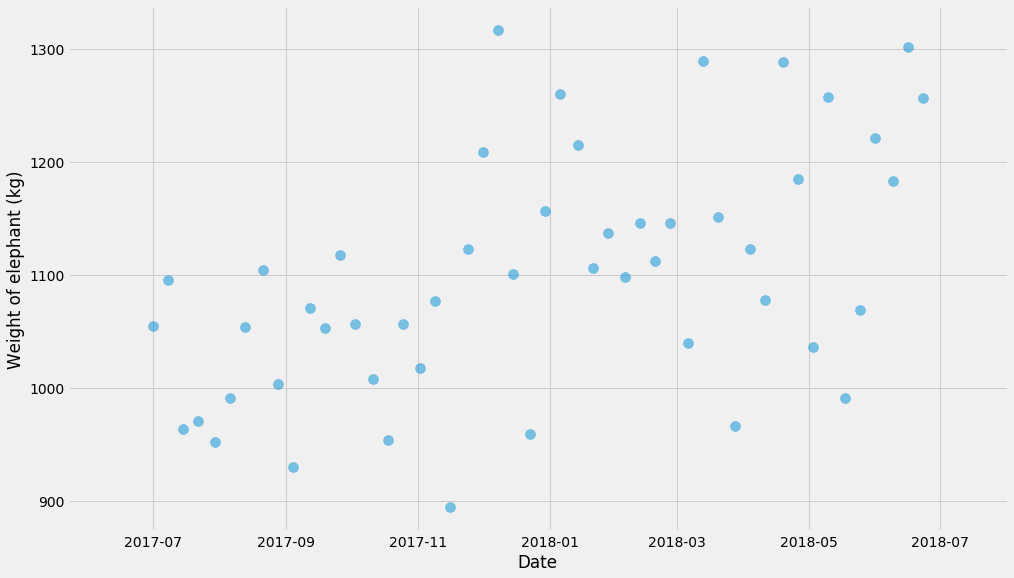

In [28]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.xlabel('Date')
pyplot.ylabel('Weight of elephant (kg)');

We can estimate the distribution for many things:
* the data itself. Given a time frame $(t, t')$, what's the distribution of the elephant's weight during that time interval?
* The uncertainty of some parameter, like the parameter $k$ in the formula $y = kt + m$. Or the uncertainty of some estimator like the mean of a number of observations. 
* The uncertainty of predicted quantities. So if we predict the weight of the elepahnt at for some date $t$, the elephant is going to weight $y$ kg, we want to know the uncertainty of the quantity $y$

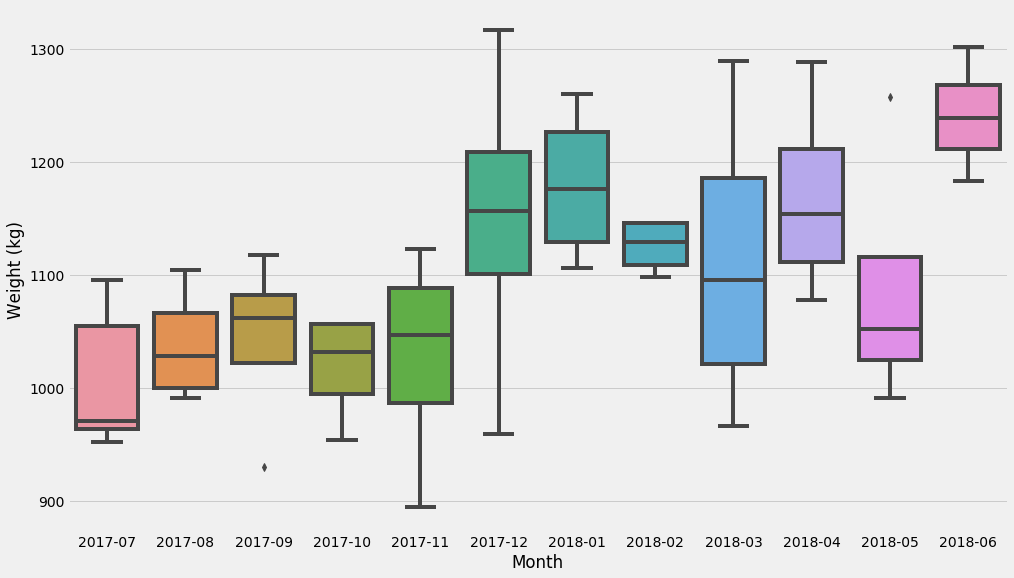

In [29]:
d = pandas.DataFrame({'x': xs, 't': ts, 'Weight (kg)': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
seaborn.boxplot(data=d, x='Month', y='Weight (kg)');

### Computing the uncertainty of the mean — normal distributions
We can compute the confidence interval of the mean by computing:
$$\bar{x} \pm 1.96 \frac{\sigma}{\sqrt{n}}$$

Just remember that the size of the confidence interval is inversely related to the square root of the number of samples. For instance, this is useful when running AB tests — if you want to detect a $1%$ the you need something in the order of $0.01^{-2} = 10,000$ samples. 

Also, where does that `1.96` come from? It's directly related to the size of the uncertainty estimate. With $\pm1.96$ you'll cover $95%$ of the probability distribution. 

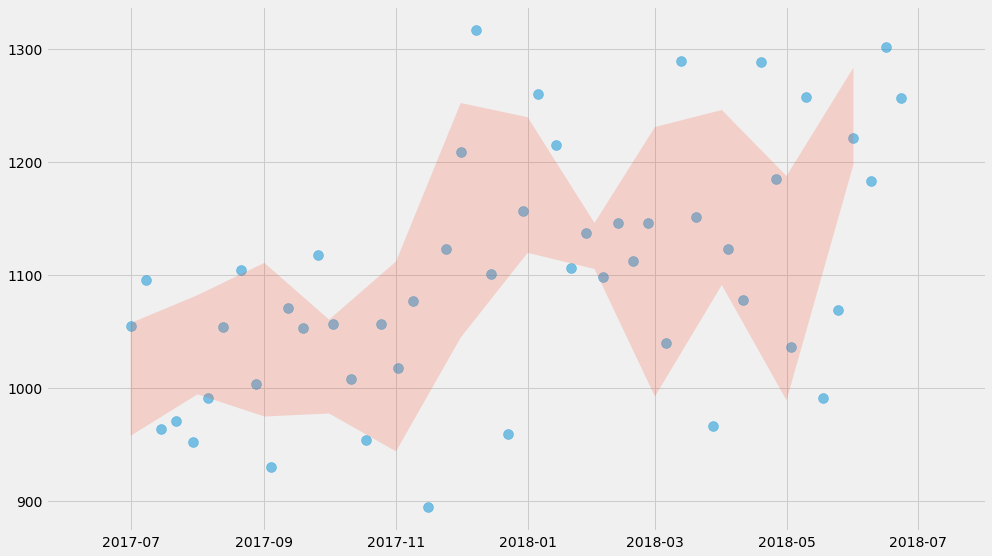

In [39]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = numpy.mean(series), numpy.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    pyplot.fill_between(groups, lo_bound, hi_bound, alpha=0.2,
                        label='Confidence interval (normal)')
    
pyplot.scatter(ts, ys, alpha=0.5, s=100)
observations_by_month = {}
for month, y in zip(d['Month'], d['Weight (kg)']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)

This shows the `uncertainty of the mean`, and not of the data itself. That's why there's far fewer than 95% of the data in within the confidence interval. Adding more points would lead the red area to get more narrow. We'd expect the true mean to fall within this range 95% of the time. 

### Confidence intervals when outcome's are 0 or 1
Let's start working with conversion data. 

In [16]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    # Don't pay too much attention to this code. The main thing happens in
    # numpy.random.binomial, which is where we draw the "k out of n" outcomes.
    output = {}
    e_obs_per_state = numpy.random.exponential(k, size=len(states))
    state_biases = numpy.random.normal(b, b_std, size=len(states))
    for group, z in zip(groups, zs):
        noise = numpy.random.normal(z, z_std, size=len(states))
        ps = 1 / (1 + numpy.exp(-(state_biases + noise)))
        ns = numpy.random.poisson(e_obs_per_state)
        ks = numpy.random.binomial(ns, ps)
        output[group] = (ns, ks)
    return output

For each state and each group we (test and control) we generate $n$ users, out of which $k$ have converted. 

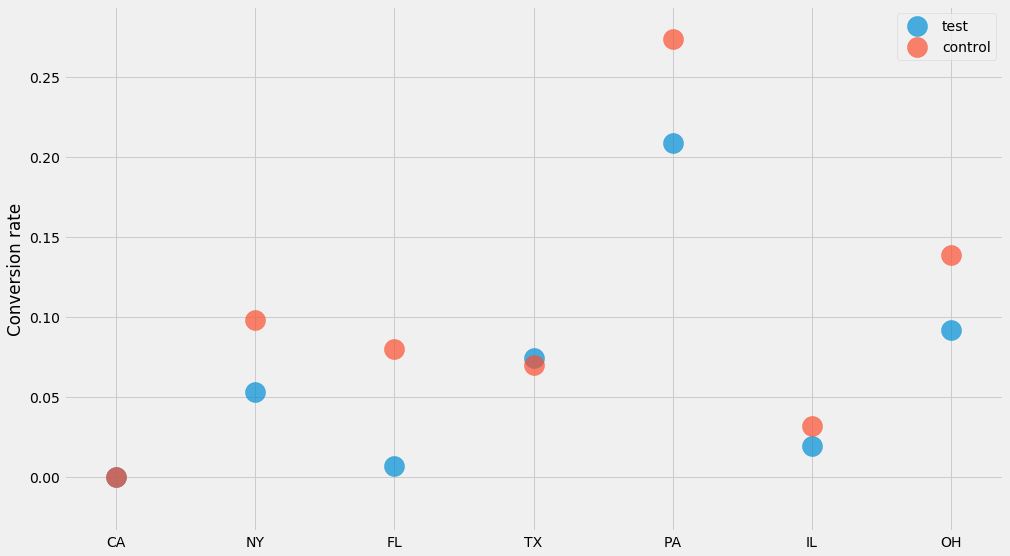

In [31]:
data = generate_binary_categorical()

for group, (ns, ks) in data.items():
    pyplot.scatter(STATES, ks/ns, label=group, alpha=0.7, s=400)

pyplot.ylabel('Conversion rate')
pyplot.legend();

In [18]:
n, k = 100, 3
scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])

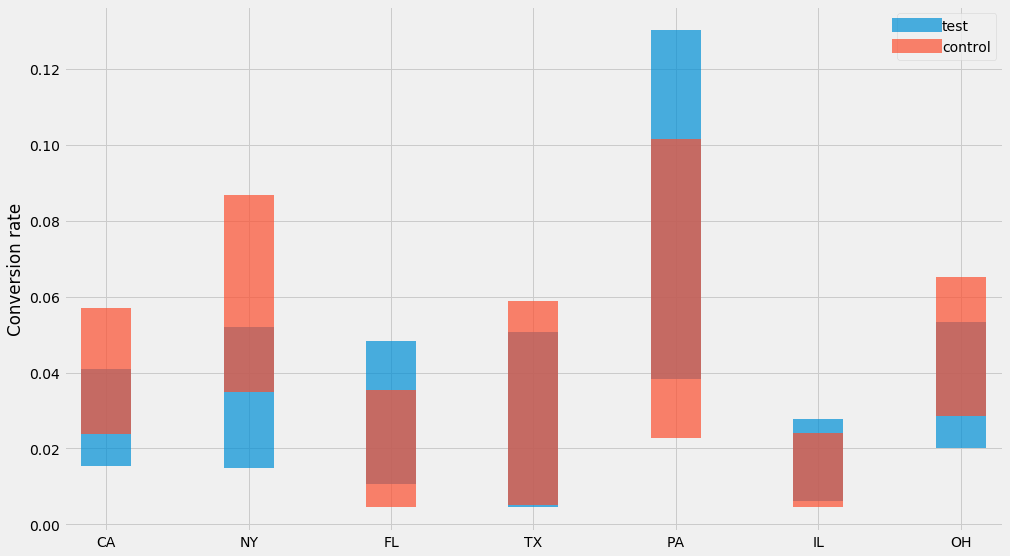

In [19]:
for group, (ns, ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025, ks, ns-ks)
    hi = scipy.stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    pyplot.errorbar(STATES, y=mean, yerr=[mean-lo, hi-mean],
                    label=group, alpha=0.7, linewidth=0, elinewidth=50)

pyplot.ylabel('Conversion rate')
pyplot.legend()

2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06


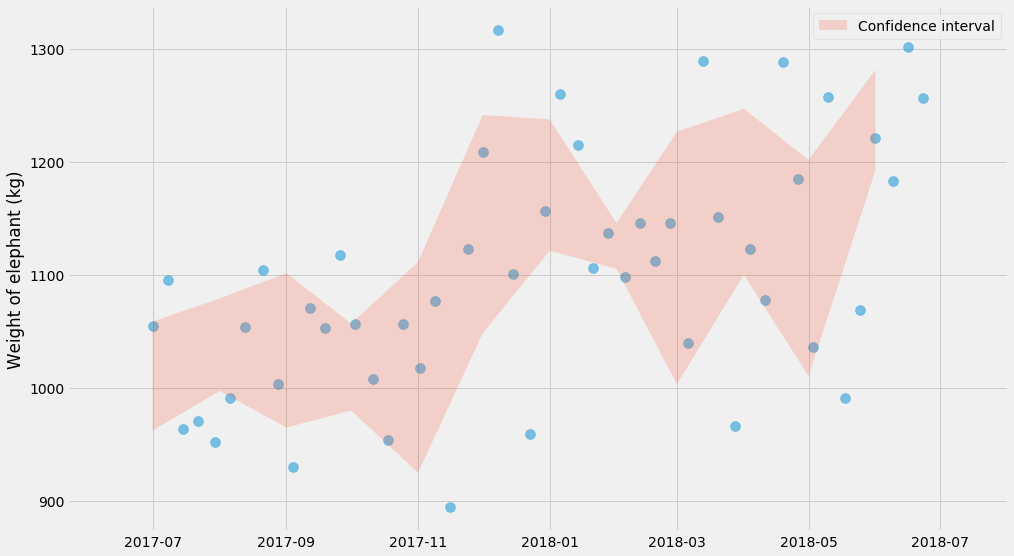

In [35]:
lo_bound = []
hi_bound = []
months = sorted(observations_by_month.keys())
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        # sample with replacement
        bootstrap = [random.choice(series) for _ in series]
        bootstrapped_means.append(numpy.mean(bootstrap))
    lo_bound.append(numpy.percentile(bootstrapped_means, 2.5))
    hi_bound.append(numpy.percentile(bootstrapped_means, 97.5))
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2,
                    label='Confidence interval')
pyplot.ylabel('Weight of elephant (kg)')
pyplot.legend()

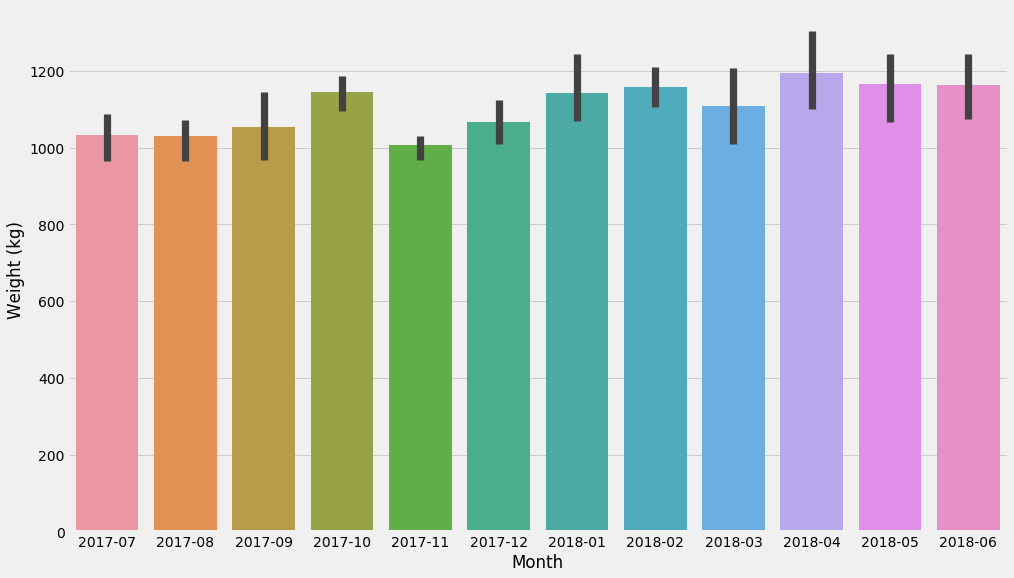

In [21]:
seaborn.barplot(data=d, x='Month', y='Weight (kg)')

Text(0, 0.5, 'Weight of elephant (kg)')

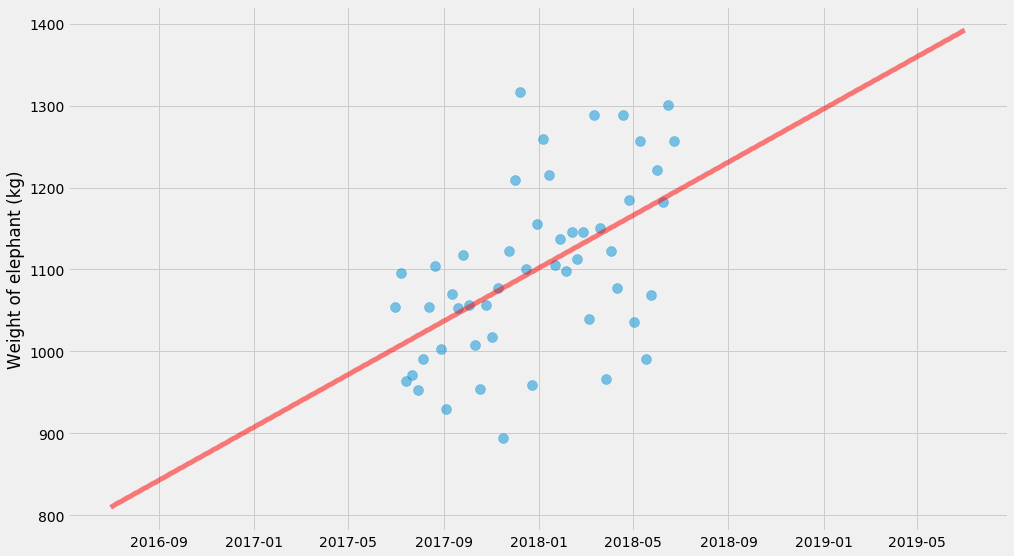

In [22]:


xs, ys, ts, x_scale, t_scale = generate_time_series()

def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return numpy.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='red', linewidth=5, alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')



No handles with labels found to put in legend.


Text(0, 0.5, 'Weight of elephant (kg)')

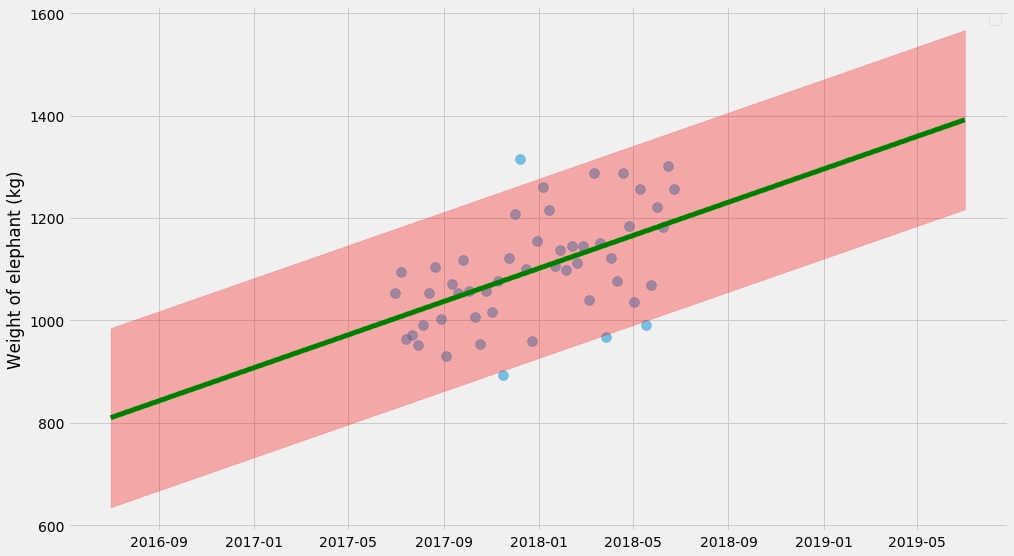

In [23]:


import scipy.optimize

def neg_log_likelihood(tup, xs, ys):
    # Since sigma > 0, we use use log(sigma) as the parameter instead.
    # That way we have an unconstrained problem.
    k, m, log_sigma = tup
    sigma = numpy.exp(log_sigma)
    delta = model(xs, k, m) - ys
    return len(xs)/2*numpy.log(2*numpy.pi*sigma**2) + \
        numpy.dot(delta, delta) / (2*sigma**2)

k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
    neg_log_likelihood, (0, 0, 0), args=(xs, ys)
).x
sigma_hat = numpy.exp(log_sigma_hat)
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='green', linewidth=5)
pyplot.fill_between(
    t_scale,
    model(x_scale, k_hat, m_hat) - 1.96*sigma_hat,
    model(x_scale, k_hat, m_hat) + 1.96*sigma_hat,
    color='red', alpha=0.3)
pyplot.legend()
pyplot.ylabel('Weight of elephant (kg)')



/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0, 0.5, 'Weight of elephant (kg)')

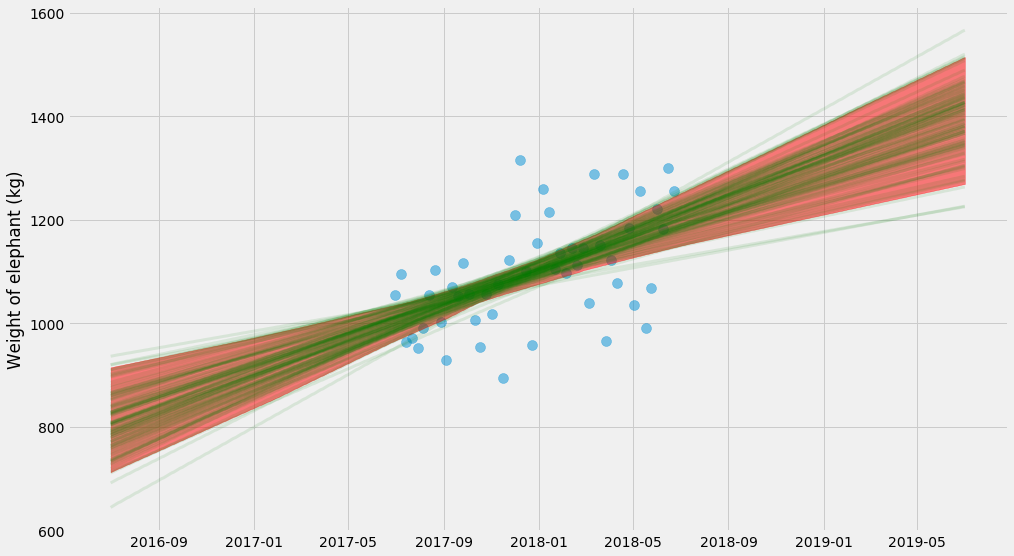

In [24]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(100):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(
        l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(model(x_scale, k_hat, m_hat))

# Plot individual lines
for curve in curves:
    pyplot.plot(t_scale, curve, alpha=0.1, linewidth=3, color='green')

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0, 0.5, 'Weight of elephant (kg)')

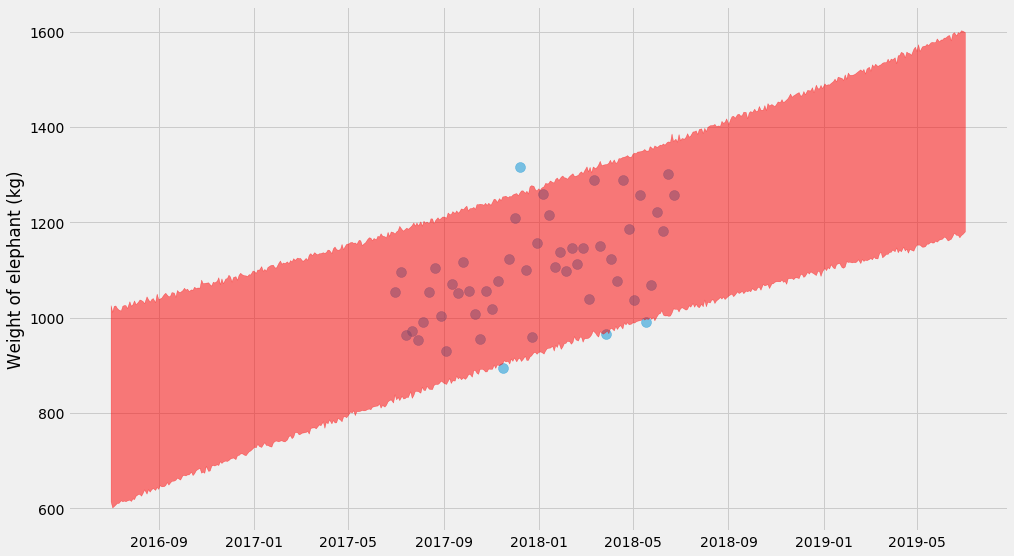

In [25]:


pyplot.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(4000):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
        neg_log_likelihood, (0, 0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(
        model(x_scale, k_hat, m_hat) +
        # Note what's going on here: we're _adding_ the random term to the predictions!
        numpy.exp(log_sigma_hat) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')



/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0, 0.5, 'Weight of elephant (kg)')

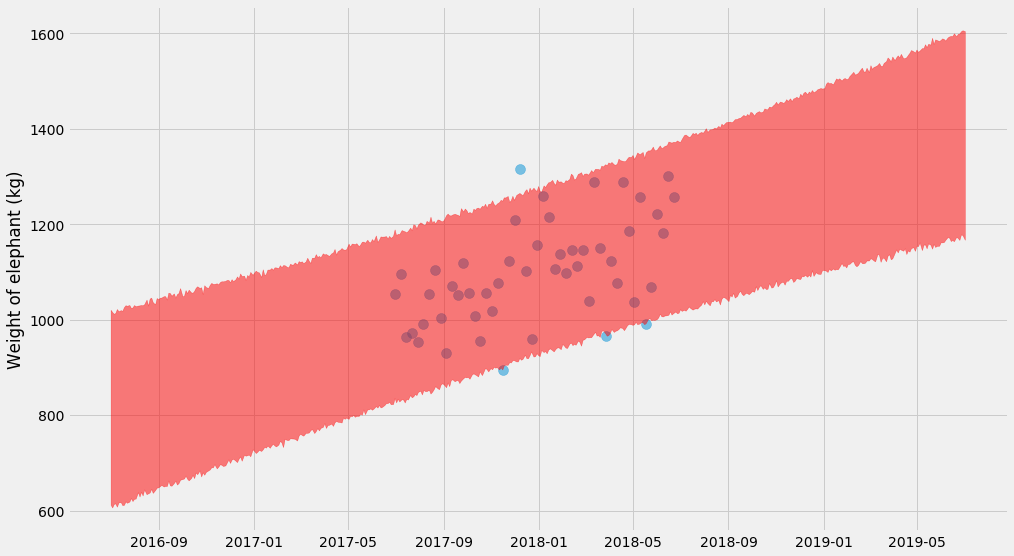

In [26]:


pyplot.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(4000):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
        neg_log_likelihood, (0, 0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(
        model(x_scale, k_hat, m_hat) +
        # Note what's going on here: we're _adding_ the random term to the predictions!
        numpy.exp(log_sigma_hat) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')



In [27]:


# Grab slightly more samples this time
samples = sampler.chain[:, -500:, :].reshape((-1, ndim))
k_samples, m_samples, log_sigma_samples = samples.T
seaborn.distplot(k_samples, label='k')
seaborn.distplot(m_samples, label='m')
seaborn.distplot(numpy.exp(log_sigma_samples), label='sigma')
pyplot.legend()



NameError: name 'sampler' is not defined

In [ ]:


pyplot.scatter(ts, ys, alpha=0.5, s=100)
samples = sampler.chain[:, -4000:, :].reshape((-1, ndim))
curves = []
for k, m, log_sigma in samples:
    curves.append(
        model(x_scale, k, m) +
        numpy.exp(log_sigma) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')



### Resources:
* [Erik Bernhardson — A Hacker's Guide to Uncertainty Estimates](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html)
* [Khan Academy](https://www.khanacademy.org/math/statistics-probability/confidence-intervals-one-sample)